### Load Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.svm import SVC

from sklearn import set_config
set_config(display='diagram')


plt.style.use('bmh')

### Load Data

In [4]:

data = pd.read_csv("../data/train.csv",index_col=0)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# check missing values
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Exploratory Data Analysis

number of survived and non_survived passengers

In [6]:
y = data['Survived']
survived = sum(y == 1)
not_survived = sum(y == 0)

print("survived : %s \nnon_survived: %s" 
     %(survived,not_survived))

survived : 342 
non_survived: 549


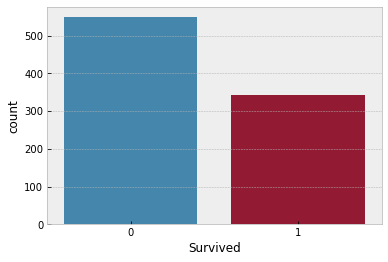

In [7]:
sns.countplot(x='Survived',data=data);

proportion of surviving 1st class passengers with regards to the total number of 1st class passengers

In [8]:
data_first_class = data [data['Pclass'] == 1] 
data_first_class_survived = data[(data['Pclass'] == 1) & (data['Survived'] == 1)]

prop = data_first_class_survived.shape[0] / data_first_class.shape[0] * 100
print(f'{round(prop,2)} percent of 1st class passengers were survived.') 

62.96 percent of 1st class passengers were survived.


Bar chart for Sex

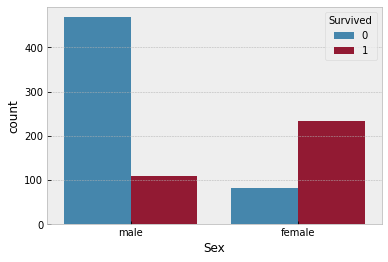

In [9]:
sns.countplot(data = data, x = 'Sex', hue = "Survived");

Bar chart for  Pclass

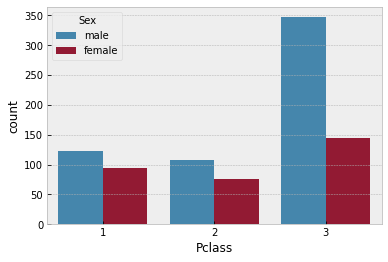

In [10]:
sns.countplot(x='Pclass',data=data,hue='Sex');

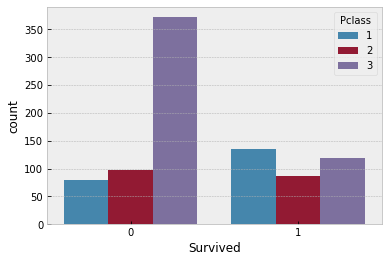

In [11]:
sns.countplot(x="Survived", data = data, hue = "Pclass");

Age distribution

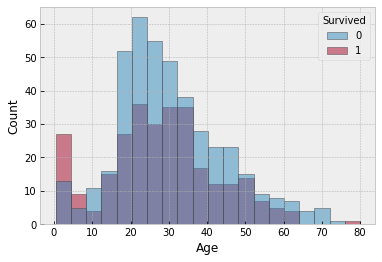

In [12]:
sns.histplot(
    data = data,
    x = "Age", hue="Survived",
    multiple='layer',
    edgecolor=".3",
    linewidth=.5,
);

In [13]:
mean_age_s = data[data['Survived'] == 1].Age.mean()
mean_age_n = data[data['Survived'] == 0].Age.mean()

print(f'average age of survived passengers is: {round(mean_age_s,2)}\naverage age of non_survived passengers is : {round(mean_age_n,2)}.')


average age of survived passengers is: 28.34
average age of non_survived passengers is : 30.63.


Fare distribution

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

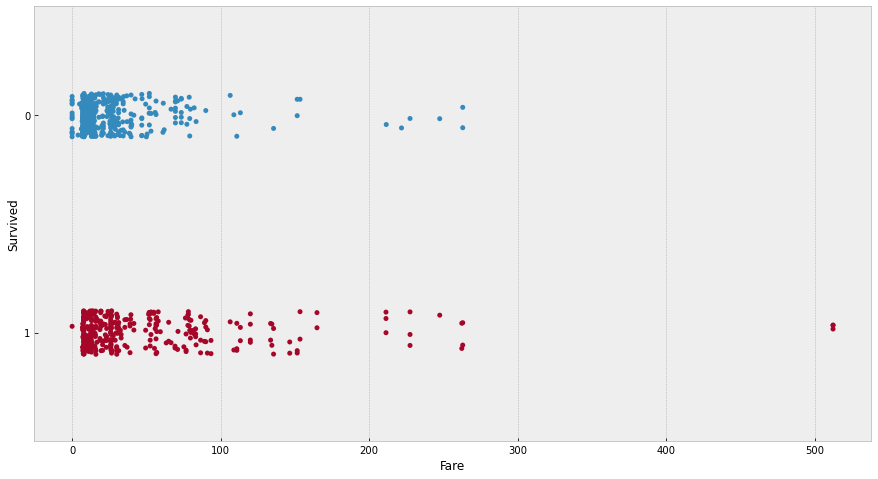

In [14]:
plt.figure(figsize=(15,8))
sns.stripplot(x=data["Fare"], y=data["Survived"].astype(str), size = 5)

Bar chart for Embarked

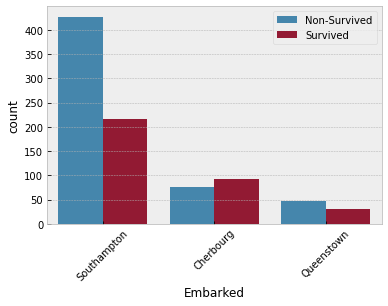

In [15]:
ax = sns.countplot(x='Embarked',data=data,hue='Survived');
ax.set_xticklabels(['Southampton','Cherbourg','Queenstown']);
plt.xticks(rotation = 45);
plt.legend(['Non-Survived', 'Survived']);

Bar chart for Relatives (SibSp + Parch)

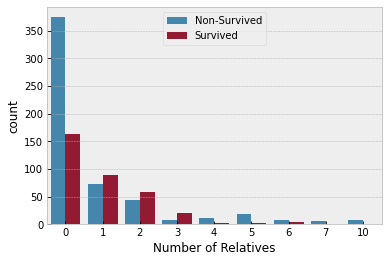

In [16]:
data['Relatives'] = data['SibSp'] + data['Parch'] 
ax = sns.countplot(x='Relatives',data=data,hue='Survived');
ax.set_xlabel("Number of Relatives")
plt.legend(['Non-Survived', 'Survived']);

Define small and large families

In [17]:
cut_bins = [-0.1,3,10]
cut_labels= ['small','big']
data['Family']= pd.cut(data['Relatives'], bins=cut_bins,labels=cut_labels,ordered = False)
data.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Family
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,small
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,small
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,small


Bar chart for family size

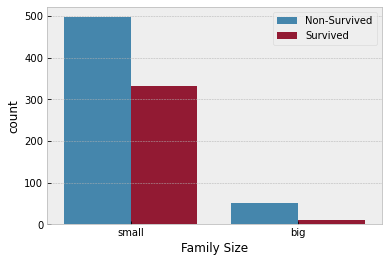

In [18]:
ax = sns.countplot(x='Family',data=data,hue='Survived');
ax.set_xlabel("Family Size")
plt.legend(['Non-Survived', 'Survived']);

In [19]:
data.groupby(["Survived","Family"]).count()[['Pclass']]

Pclass
Survived Family        
0        small      497
         big         52
1        small      332
         big         10

### Logistic Regression

In [20]:
# define features and target
X = data.drop(['Survived','SibSp','Parch','Family'], axis=1)
y = data['Survived']

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     891 non-null    int64  
 1   Name       891 non-null    object 
 2   Sex        891 non-null    object 
 3   Age        714 non-null    float64
 4   Ticket     891 non-null    object 
 5   Fare       891 non-null    float64
 6   Cabin      204 non-null    object 
 7   Embarked   889 non-null    object 
 8   Relatives  891 non-null    int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 69.6+ KB


In [22]:
# Train-test split of the data
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=100)

#### Feature Engineering

In [23]:
# data summary
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    int64   
 2   Name       891 non-null    object  
 3   Sex        891 non-null    object  
 4   Age        714 non-null    float64 
 5   SibSp      891 non-null    int64   
 6   Parch      891 non-null    int64   
 7   Ticket     891 non-null    object  
 8   Fare       891 non-null    float64 
 9   Cabin      204 non-null    object  
 10  Embarked   889 non-null    object  
 11  Relatives  891 non-null    int64   
 12  Family     891 non-null    category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 91.5+ KB


**Columns and summarizing thoughts for logisitc regression:**

`Pclass`: Since it is ordinal and already numeric, keep it as it is 

`Name:` Length of name might be a useful feature

`Sex:` Categorical, but not ordinal, needs onehot encoding

`Àge:` Numerical data, impute (e.g. mean of class), needs binning 

`SibSp:` Numerical data, It is not considered in the features. Insetead of it, Relatives is considered 

`Parch:` Numerical data, It is not considered in the features. Insetead of it, Relatives is considered 

`Relatives:` Numerical data, It is sum of SibSb and Parch, needs binning 

`Ticket:` It is not considered in the Features

`Fare:` Scaling definitely needed, outliers to be considered (see box plot)

`Cabin:` Extract first letter and length of number, 

`Èmbarked:` Imputing (most frequent), needs onehot encoding

##### Define Pipelines

In [24]:
# Name
def name_length(df):
    length = df['Name'].str.len()
    return length.values.reshape(-1, 1)

name_pipe_lr = make_pipeline(
     FunctionTransformer(name_length)
)

In [25]:
# Sex
sex_pipe_lr = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [26]:
# Age
age_pipe_lr = make_pipeline(
   SimpleImputer(strategy='mean'),
   KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform'))

In [27]:
# Relatieves
rel_pipe_lr = make_pipeline(
   KBinsDiscretizer(n_bins=2, encode='onehot-dense', strategy='uniform')
)

In [28]:
# Fare
fare_pipe_lr = make_pipeline(
    RobustScaler() # Handles outliers better than other scalers
)

In [29]:
# Cabin
def get_deck(df):
    # fill  values with N
    df.fillna('N',inplace = True)
    # extract deck from cabin
    deck = df.iloc[:,0].apply(lambda x: str(x)[0].upper())
    # replace T with N (T counted as unknown)
    for idx, item in deck.items():
        deck[idx] = item.replace('T', 'N')   
    return deck.values.reshape(-1,1)

cab_pipe_lr = make_pipeline(
    FunctionTransformer(get_deck),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [30]:
# Embarked
emb_pipe_lr = make_pipeline(
   SimpleImputer(strategy='most_frequent'),
   OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [31]:
# summarize in columntransformer for preprocessing
feature_transform_lr = ColumnTransformer([
    ('do_nothing', 'passthrough', ['Pclass']),
    ('name_length', name_pipe_lr, ['Name']),
    ('onehot_encoding',sex_pipe_lr,['Sex']),
    ('impute_and_binning',age_pipe_lr,['Age']),
    ('relatives',rel_pipe_lr,['Relatives']),
    ('scale',fare_pipe_lr,['Fare']),
    ('get_deck',cab_pipe_lr,['Cabin']),
    ('impute_and_onehot_encoding',emb_pipe_lr,['Embarked'])
])

#### Create Classifier

In [32]:
# create logistic regression mdoel
lr = Pipeline([
   ('preprocessing',feature_transform_lr),
   ('m_lr',LogisticRegression(C=1e9,max_iter=3000))
])

In [33]:
lr.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fcbd12631f0>))]),
                                                  ['Name']),
                                                 ('onehot_encoding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Sex']...
                                                                   FunctionTransformer(func=<function get_deck at 0x7fcbd135a0d0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Cabin']),
                                                 ('impute_and_onehot_encoding',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked'])])),
                ('m_lr', LogisticRegression(C=1000000000.0, max_iter=3000))])

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


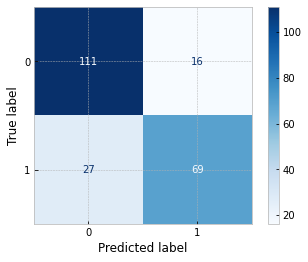

In [34]:
# plot confusion matrix
metrics.plot_confusion_matrix(lr, X_test, y_test,
                              values_format=".4g", 
                              cmap='Blues'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


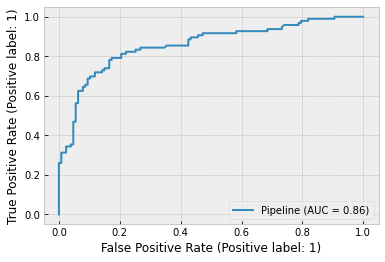

In [35]:
metrics.plot_roc_curve(lr, X_test, y_test)

In [36]:
def print_evaluation_metrics(model,X_train,y_train,X_test,y_test):
    
    """ Print out some evaluation metrics """
    
    print(f'train score: {round(model.score(X_train,y_train),2)}')
    print(f'test score: {round(model.score(X_test,y_test),2)}')
    

In [37]:
print_evaluation_metrics(lr,X_train,y_train,X_test,y_test)

train score: 0.83
test score: 0.81


In [38]:
# save evaluation metrics using cross validation
def save_evaluation_metrics(classifier,classifier_name, summary, X, y):
    
    AUC = round(cross_val_score(classifier, X, y, cv = 5, scoring='roc_auc').mean(),2)
    accuracy = round(cross_val_score(classifier, X, y, cv = 5, scoring='accuracy').mean(),2)
    precision = round(cross_val_score(classifier, X, y, cv = 5, scoring='precision').mean(),2)
    recall = round(cross_val_score(classifier, X, y, cv = 5, scoring='recall').mean(),2)
    f1 = round(cross_val_score(classifier, X, y, cv = 5, scoring='f1').mean(),2)
    
    summary['Classifier Name'].append(classifier_name)
    summary['AUC'].append(AUC)
    summary['Accuracy'].append(accuracy)
    summary['Precision'].append(precision)
    summary['Recall'].append(recall)
    summary['F1'].append(f1)
    
    
    return summary

In [39]:
summary = {'Classifier Name':[],'AUC':[],'Accuracy':[]
           ,'Precision':[],'Recall':[],'F1':[]}

summary = save_evaluation_metrics(lr,'Logistic Regressin',summary,X,y)
summary

{'Classifier Name': ['Logistic Regressin'],
 'AUC': [0.85],
 'Accuracy': [0.79],
 'Precision': [0.73],
 'Recall': [0.7],
 'F1': [0.72]}

### Decision Tree

#### Feature Engineering

Pipelines to be redesigned - no scalling and onehote encoding needed

##### Define Pipelines

In [40]:
# Name
name_pipe_dt = make_pipeline(
    FunctionTransformer(name_length),
)

In [41]:
# Sex
sex_pipe_dt = make_pipeline(
    OrdinalEncoder()
)

In [42]:
# Fare
fare_pipe_dt = make_pipeline(
    SimpleImputer(strategy='mean')
)

In [43]:
# Age
age_pipe_dt = make_pipeline(
    SimpleImputer(strategy='mean'),
)

In [44]:
# Cabin
cab_pipe_dt = make_pipeline(
     FunctionTransformer(get_deck),
     OrdinalEncoder()
)

In [45]:
# Embarked
emb_pipe_dt = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder()
)

In [46]:
feature_transform_dt = ColumnTransformer([
    ('do_nothing', 'passthrough', ['Pclass', 'Relatives']),
    ('sex_categorization', sex_pipe_dt, ['Sex']),
    ('fare_imputation', fare_pipe_dt, ['Fare']),
    ('age_imputing', age_pipe_dt, ['Age']),
    ('get_deck', cab_pipe_dt, ['Cabin']),
    ('impute_and_ordinal_encoder', emb_pipe_dt, ['Embarked']),
    ('name_length', name_pipe_dt, ['Name'])
])

In [47]:
feature_names_dt = ([
                        'Pclas', 'Relatives',
                        'Sex',
                        'Fare',
                        'Age',
                        'Cabin',
                        'Embarked',
                        'Name',
])

#### Create Classifier

In [48]:
dt = Pipeline([
    ('preprocessing',feature_transform_dt),
    ('m_dt',DecisionTreeClassifier(max_depth=4))
])

In [49]:
dt.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass', 'Relatives']),
                                                 ('sex_categorization',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('fare_imputation',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['Fare']),
                                                 ('age_imputing',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())])...
                                                                   OrdinalEncoder())]),
                                                  ['Cabin']),
                                                 ('impute_and_ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Embarked']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fcbd12631f0>))]),
                                                  ['Name'])])),
                ('m_dt', DecisionTreeClassifier(max_depth=4))])

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


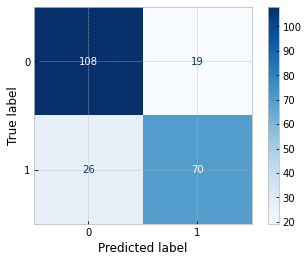

In [50]:
# plot confusion matrix
metrics.plot_confusion_matrix(dt, X_test, y_test,
                              values_format=".4g", 
                              cmap='Blues'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


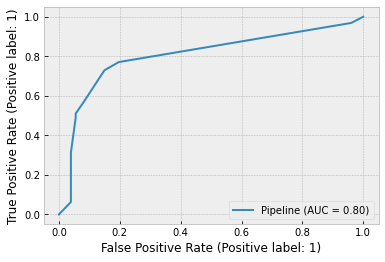

In [51]:
metrics.plot_roc_curve(dt, X_test, y_test)

In [52]:
print_evaluation_metrics(dt,X_train,y_train,X_test,y_test)

train score: 0.85
test score: 0.8


In [53]:
summary = save_evaluation_metrics(dt,'Decision Tree',summary, X,y)
summary

{'Classifier Name': ['Logistic Regressin', 'Decision Tree'],
 'AUC': [0.85, 0.84],
 'Accuracy': [0.79, 0.8],
 'Precision': [0.73, 0.78],
 'Recall': [0.7, 0.66],
 'F1': [0.72, 0.71]}

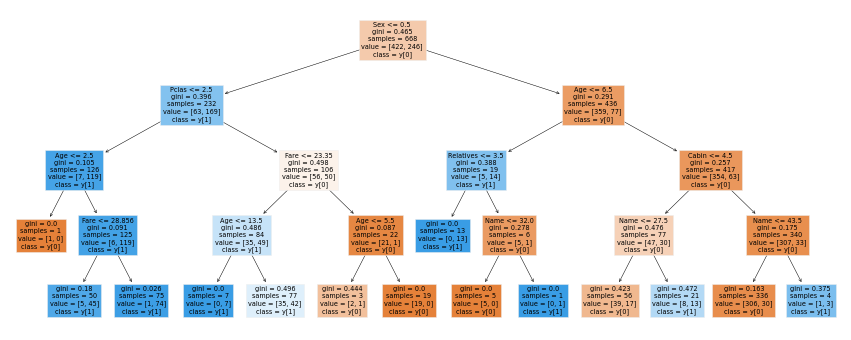

In [54]:
# Check tree and features used
plt.figure(figsize = (15,6))
plot_tree(dt['m_dt'], feature_names = feature_names_dt,class_names = True, filled = True);

In [55]:
# Feature importance
importance = pd.DataFrame(dt['m_dt'].feature_importances_)
importance.index = feature_names_dt

display(importance.sort_values(by = 0, ascending = False).head(10))

,0
Sex,0.540606
Pclas,0.150833
Age,0.102555
Cabin,0.062993
Fare,0.061773
Name,0.047819
Relatives,0.033422
Embarked,0.000000


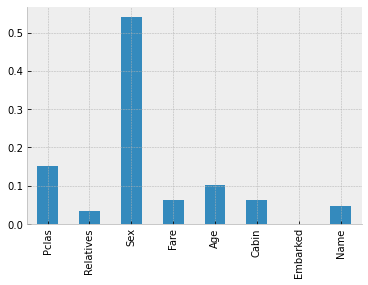

In [56]:
importance.plot.bar(legend=False)
sns.despine()

### Random Forest

#### Feature Engineering

##### Define Pielines

Decision tree's feature pipeline can be reused

#### Create Classifier

In [57]:
rf = Pipeline([
            ('preprocessor', feature_transform_dt),
            ('m_rf', RandomForestClassifier(n_estimators=100, max_depth=4))
])

In [58]:
rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass', 'Relatives']),
                                                 ('sex_categorization',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex']),
                                                 ('fare_imputation',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['Fare']),
                                                 ('age_imputing',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),...
                                                                   OrdinalEncoder())]),
                                                  ['Cabin']),
                                                 ('impute_and_ordinal_encoder',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Embarked']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fcbd12631f0>))]),
                                                  ['Name'])])),
                ('m_rf', RandomForestClassifier(max_depth=4))])

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


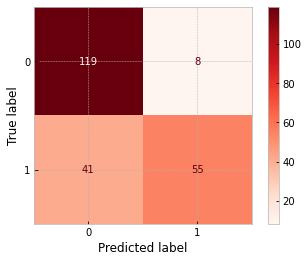

In [59]:
# plot confusion matrix
metrics.plot_confusion_matrix(rf, X_test, y_test,
                              values_format=".4g", 
                              cmap='Reds'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


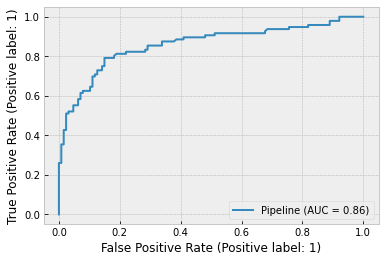

In [60]:
metrics.plot_roc_curve(rf, X_test, y_test)

In [61]:
print_evaluation_metrics(rf,X_train,y_train,X_test,y_test)

train score: 0.86
test score: 0.78


In [62]:
summary = save_evaluation_metrics(rf,'Random Forest',summary, X, y)
summary

{'Classifier Name': ['Logistic Regressin', 'Decision Tree', 'Random Forest'],
 'AUC': [0.85, 0.84, 0.86],
 'Accuracy': [0.79, 0.8, 0.8],
 'Precision': [0.73, 0.78, 0.83],
 'Recall': [0.7, 0.66, 0.65],
 'F1': [0.72, 0.71, 0.72]}

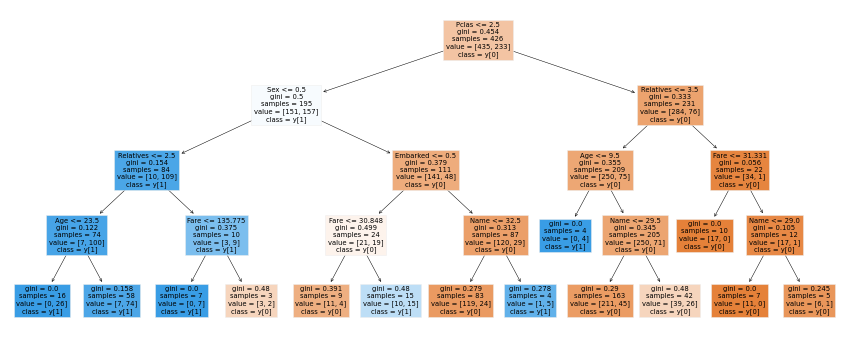

In [63]:
# Check tree and features used
plt.figure(figsize = (15,6))
plot_tree(rf['m_rf'][0], feature_names = feature_names_dt,class_names = True, filled = True);

In [64]:
# Feature importance
importance = pd.DataFrame(rf['m_rf'].feature_importances_)
importance.index = feature_names_dt

display(importance.sort_values(by = 0, ascending = False).head(10))

,0
Sex,0.365267
Fare,0.143197
Name,0.129306
Pclas,0.122891
Cabin,0.096052
Age,0.071790
Relatives,0.052024
Embarked,0.019473


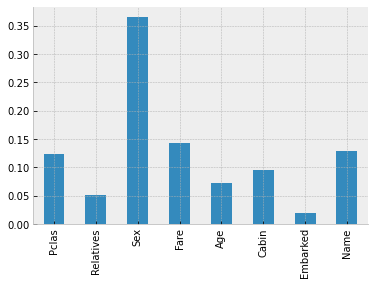

In [65]:
importance.plot.bar(legend=False)
sns.despine()

### Support Vector Machine

#### Feature Engineering

##### Define Pipelines

Logistic Regression's feature pipeline can be reused

#### Create Classifier

In [66]:
svm = Pipeline([
                ('preprocessor', feature_transform_lr),
                ('m_svm', SVC(kernel='rbf', C=10, probability=True))
])

In [67]:
svm.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass']),
                                                 ('name_length',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function name_length at 0x7fcbd12631f0>))]),
                                                  ['Name']),
                                                 ('onehot_encoding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Sex'])...
                                                                   FunctionTransformer(func=<function get_deck at 0x7fcbd135a0d0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Cabin']),
                                                 ('impute_and_onehot_encoding',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked'])])),
                ('m_svm', SVC(C=10, probability=True))])

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


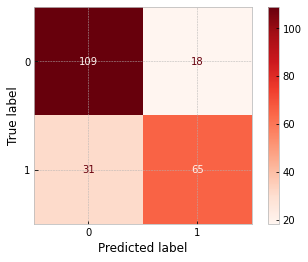

In [68]:
# plot confusion matrix
metrics.plot_confusion_matrix(svm, X_test, y_test,
                              values_format=".4g", 
                              cmap='Reds'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


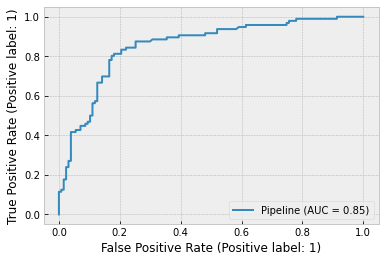

In [69]:
metrics.plot_roc_curve(svm, X_test, y_test)

In [70]:
print_evaluation_metrics(svm,X_train,y_train,X_test,y_test)

train score: 0.8
test score: 0.78


In [71]:
summary = save_evaluation_metrics(svm,'Support Vector Machine',summary, X, y)
summary

{'Classifier Name': ['Logistic Regressin',
  'Decision Tree',
  'Random Forest',
  'Support Vector Machine'],
 'AUC': [0.85, 0.84, 0.86, 0.85],
 'Accuracy': [0.79, 0.8, 0.8, 0.79],
 'Precision': [0.73, 0.78, 0.83, 0.74],
 'Recall': [0.7, 0.66, 0.65, 0.7],
 'F1': [0.72, 0.71, 0.72, 0.72]}

### Voting Classifier

#### Create Classifier

In [72]:
vot = VotingClassifier(estimators=[
        ('lr',lr), 
        ('dt',dt), 
        ('rf', rf), 
        ('svm', svm)],       
        voting='soft'
)

In [73]:
vot.fit(X_train,y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('do_nothing',
                                                                                'passthrough',
                                                                                ['Pclass']),
                                                                               ('name_length',
                                                                                Pipeline(steps=[('functiontransformer',
                                                                                                 FunctionTransformer(func=<function name_length at 0x7fcbd12631f0>))]),
                                                                                ['Name']),
                                                                               ('onehot_encoding',
                                                                                Pipeline(steps=[('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknow...
                                                                                                 FunctionTransformer(func=<function get_deck at 0x7fcbd135a0d0>)),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['Cabin']),
                                                                               ('impute_and_onehot_encoding',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['Embarked'])])),
                                              ('m_svm',
                                               SVC(C=10, probability=True))]))],
                 voting='soft')

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


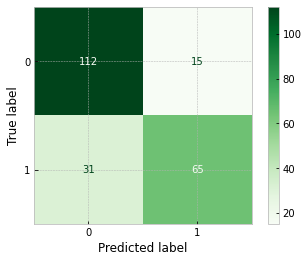

In [74]:
# plot confusion matrix
metrics.plot_confusion_matrix(vot, X_test, y_test,
                              values_format=".4g", 
                              cmap='Greens'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


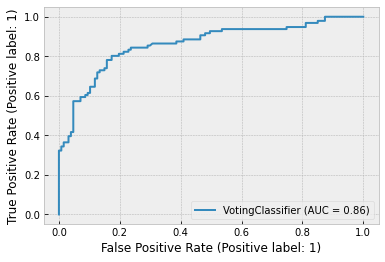

In [75]:
metrics.plot_roc_curve(vot, X_test, y_test)

In [76]:
print_evaluation_metrics(vot,X_train,y_train,X_test,y_test)

train score: 0.85
test score: 0.79


In [77]:
summary = save_evaluation_metrics(vot,'Votting Classifier',summary, X, y)
summary

{'Classifier Name': ['Logistic Regressin',
  'Decision Tree',
  'Random Forest',
  'Support Vector Machine',
  'Votting Classifier'],
 'AUC': [0.85, 0.84, 0.86, 0.85, 0.87],
 'Accuracy': [0.79, 0.8, 0.8, 0.79, 0.82],
 'Precision': [0.73, 0.78, 0.83, 0.74, 0.79],
 'Recall': [0.7, 0.66, 0.65, 0.7, 0.71],
 'F1': [0.72, 0.71, 0.72, 0.72, 0.75]}

### Compare Performance of Classifiers

In [78]:
summary = pd.DataFrame(summary)
summary.set_index('Classifier Name',inplace=True)
summary

,AUC,Accuracy,Precision,Recall,F1
Classifier Name,,,,,
Logistic Regressin,0.85,0.79,0.73,0.70,0.72
Decision Tree,0.84,0.80,0.78,0.66,0.71
Random Forest,0.86,0.80,0.83,0.65,0.72
Support Vector Machine,0.85,0.79,0.74,0.70,0.72
Votting Classifier,0.87,0.82,0.79,0.71,0.75


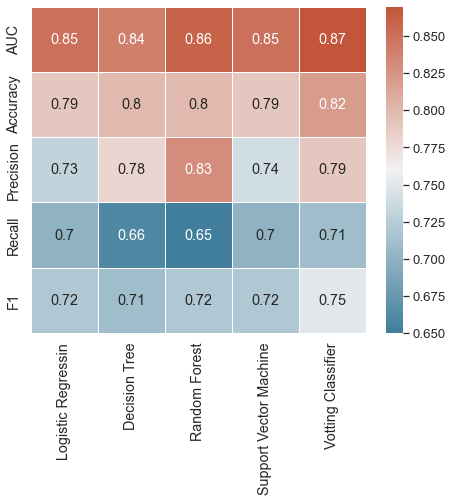

In [91]:
f, ax = plt.subplots(figsize=(7.5, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale = 1.2)
sns.heatmap(summary.transpose(), annot=True, cmap=cmap, linewidths=1, ax=ax)
plt.xlabel('');
image_name = '../figures/overview_ml_pm.png'
plt.savefig(image_name, dpi = 200, transparent=False,bbox_inches='tight')

#### Save Best Classifier

In [80]:
# save vote classifier
with open('../models/vot.joblib','wb') as io:
    dill.dump(vot,io)

In [81]:
# save features
features = list(X_train.columns)
with open('../models/features.joblib','wb') as io:
    dill.dump(features,io)